# IBM Data Science Professional Specialization 
### CAPSTONE PROJECT
**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **The Battle of Neighborhoods**
##  Real Estate vs Surroundings

#### Project Workflow :
1. Get the Real Estate data for each Neighborhood :
    * wesite : https://www.cityrealty.com/nyc
    * module : BeautifulSoup 
    
2. Get geographical coordinates of each Neighborhood :
    * website : https://geo.nyu.edu/catalog

3. Merge the two datasets
4. Getting the surrounding venues of each Neighborhood
    * API : FourSuare
    * Endpoint : explore?
    * Group : venues
5. Data processing for Modeling
    * PCR (PCS + LR)
6. Building Machine Learning model and Evaluation
    * R2 Score
    * Mean Squared Error (MSE)
7. Project Conclusion 

## Importing Libraries

In [1]:
# Installing the requests library to access the website through URL
pip install requests

In [2]:
# Installing the BeautifulSoup library for Web Scrapping
pip install beautifulsoup4

In [3]:
# Installing the Folium library for map visualization
pip install folium

In [4]:
# Installing the geopy library to get the geographical data
pip install geopy

In [5]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

print('Libraries imported!')

Libraries imported!


## **1. Web Scrapping - Getting the Real Estate data**

### 1.1  Scrap CityRealty website for neighborhoods average prices 
URL : https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804

In [0]:
# Using Beautiful Soup to parse the website's html

data = requests.get('https://www.cityrealty.com/nyc/market-insight/features/get-to-know/average-nyc-condo-prices-neighborhood-june-2018/18804').text
soup = BeautifulSoup(data, 'html.parser')

### 1.2  Scrap the table to get the Borough , Neighborhood and the Average price

In [0]:
# Create empty list for the Boroughs and the Neighborhoods
areaList = []
neighborhoodList = []

for area in soup.find_all("div", class_="tile _quote _n1 _last"):
    areaText = area.find("a").text
    areaList.append(areaText)
    
for index, table in enumerate(soup.find_all("table", class_="table table-bordered table-hover table-condensed")):
    for row in table.find_all("tr"):
        cells = row.find_all("td")
        if len(cells) > 0:
            neighborhoodName = cells[0].find("a").text.strip()
            avgPrice = cells[3].text.lstrip("$").strip()
            if "K" in avgPrice:
                avgPrice = float(avgPrice.rstrip("K")) * 1000
            else: 
                if "M" in avgPrice:
                    avgPrice = float(avgPrice.rstrip("M")) * 1000000
            
            neighborhoodList.append((
                areaList[index],
                neighborhoodName,
                avgPrice
            ))

### 1.3  Convert scrapped data to pandas Dataframe

In [0]:
# Put the scrapped data into a dataframe
nyc_neighborhoods_df = pd.DataFrame(neighborhoodList)
nyc_neighborhoods_df.columns = ['Area', 'Neighborhood', 'AvgPrice']

In [9]:
print(nyc_neighborhoods_df.shape)
nyc_neighborhoods_df

(54, 3)


Area                     Neighborhood  \
0                                 Brooklyn               Bedford-Stuyvesant   
1                                 Brooklyn                      Boerum Hill   
2                                 Brooklyn                 Brooklyn Heights   
3                                 Brooklyn                         Bushwick   
4                                 Brooklyn                  Carroll Gardens   
5                                 Brooklyn                     Clinton Hill   
6                                 Brooklyn                      Cobble Hill   
7                                 Brooklyn                    Crown Heights   
8                                 Brooklyn                Downtown Brooklyn   
9                                 Brooklyn                            DUMBO   
10                                Brooklyn                      Fort Greene   
11                                Brooklyn                          Gowanus   
12                                Brooklyn                       Greenpoint   
13                                Brooklyn                       Park Slope   
14                                Brooklyn                 Prospect Heights   
15                                Brooklyn        Prospect Lefferts Gardens   
16                                Brooklyn                         Red Hook   
17                                Brooklyn  South Slope - Greenwood Heights   
18                                Brooklyn                     Williamsburg   
19                                Brooklyn                  Windsor Terrace   
20  Financial District + Battery Park City                Battery Park City   
21  Financial District + Battery Park City               Financial District   
22                         Upper East Side                    Carnegie Hill   
23                         Upper East Side                       Lenox Hill   
24                         Upper East Side      Park/Fifth Ave. to 79th St.   
25                         Upper East Side                 Roosevelt Island   
26                         Upper East Side                        Yorkville   
27                                Downtown                          Chelsea   
28                                Downtown                     East Village   
29                                Downtown            Flatiron/Union Square   
30                                Downtown                    Gramercy Park   
31                                Downtown                Greenwich Village   
32                                Downtown                  Lower East Side   
33                                Downtown                             NOHO   
34                                Downtown              NoLiTa/Little Italy   
35                                Downtown                             SOHO   
36                                Downtown            Stuyvesant Town / PCV   
37                                Downtown                          Tribeca   
38                                Downtown                     West Village   
39                                 Midtown             Beekman/Sutton Place   
40                                 Midtown                     Midtown East   
41                                 Midtown                     Midtown West   
42                                 Midtown                      Murray Hill   
43                                 Midtown        Turtle Bay/United Nations   
44                         Upper Manhattan                      East Harlem   
45                         Upper Manhattan                 Hamilton Heights   
46                         Upper Manhattan                           Harlem   
47                         Upper Manhattan                           Inwood   
48                         Upper Manhattan               Washington Heights   
49                         Upper West Side                Broadway Corridor   
50       

## **2. Get the Geographical Coordinates**

### 2.1  Getting the Geodata from the geo.nyu website for free
URL : https://geo.nyu.edu/catalog/nyu_2451_34572

The data is downloaded and the file is added to the project directory as nyu-2451-34572-geojson.json

In [0]:
# Load the json file
with open('nyu-2451-34572-geojson.json') as nyc_geo_json:
    nyc_geo_data = json.load(nyc_geo_json)

In [12]:
nyc_geo_list = nyc_geo_data['features']

# Sample neighborhood node
nyc_geo_list[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

### 2.2  Extracting Borough, Neighborhood and the Coordinates

In [0]:
# Parse the json data into neighborhoods list

neighborhood_geo_list = []
for data in nyc_geo_list:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhood_geo_list.append((
        borough, neighborhood_name, neighborhood_lat, neighborhood_lon
    ))

### 2.3  Converting the JSON data into pandas Dataframe

In [0]:
# Put into a dataframe

neighborhood_geo_df = pd.DataFrame(neighborhood_geo_list)
neighborhood_geo_df.columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']


In [15]:
# Avg price data is only available for Manhattan and Brooklyn

neighborhood_geo_df = neighborhood_geo_df[(neighborhood_geo_df['Borough'] == 'Manhattan') | (neighborhood_geo_df['Borough'] == 'Brooklyn')]

neighborhood_geo_df.reset_index(drop=True, inplace=True)

neighborhood_geo_df

Borough               Neighborhood   Latitude  Longitude
0    Manhattan                Marble Hill  40.876551 -73.910660
1     Brooklyn                  Bay Ridge  40.625801 -74.030621
2     Brooklyn                Bensonhurst  40.611009 -73.995180
3     Brooklyn                Sunset Park  40.645103 -74.010316
4     Brooklyn                 Greenpoint  40.730201 -73.954241
5     Brooklyn                  Gravesend  40.595260 -73.973471
6     Brooklyn             Brighton Beach  40.576825 -73.965094
7     Brooklyn             Sheepshead Bay  40.586890 -73.943186
8     Brooklyn          Manhattan Terrace  40.614433 -73.957438
9     Brooklyn                   Flatbush  40.636326 -73.958401
10    Brooklyn              Crown Heights  40.670829 -73.943291
11    Brooklyn              East Flatbush  40.641718 -73.936103
12    Brooklyn                 Kensington  40.642382 -73.980421
13    Brooklyn            Windsor Terrace  40.656946 -73.980073
14    Brooklyn           Prospect Heights  40.676822 -73.964859
15    Brooklyn                Brownsville  40.663950 -73.910235
16    Brooklyn               Williamsburg  40.707144 -73.958115
17    Brooklyn                   Bushwick  40.698116 -73.925258
18    Brooklyn         Bedford Stuyvesant  40.687232 -73.941785
19    Brooklyn           Brooklyn Heights  40.695864 -73.993782
20    Brooklyn                Cobble Hill  40.687920 -73.998561
21    Brooklyn            Carroll Gardens  40.680540 -73.994654
22    Brooklyn                   Red Hook  40.676253 -74.012759
23    Brooklyn                    Gowanus  40.673931 -73.994441
24    Brooklyn                Fort Greene  40.688527 -73.972906
25    Brooklyn                 Park Slope  40.672321 -73.977050
26    Brooklyn              Cypress Hills  40.682391 -73.876616
27    Brooklyn              East New York  40.669926 -73.880699
28    Brooklyn              Starrett City  40.647589 -73.879370
29    Brooklyn                   Canarsie  40.635564 -73.902093
30    Brooklyn                  Flatlands  40.630446 -73.929113
31    Brooklyn                Mill Island  40.606336 -73.908186
32    Brooklyn            Manhattan Beach  40.577914 -73.943537
33    Brooklyn               Coney Island  40.574293 -73.988683
34    Brooklyn                 Bath Beach  40.599519 -73.998752
35    Brooklyn               Borough Park  40.633131 -73.990498
36    Brooklyn              Dyker Heights  40.619219 -74.019314
37    Brooklyn            Gerritsen Beach  40.590848 -73.930102
38    Brooklyn                Marine Park  40.609748 -73.931344
39    Brooklyn               Clinton Hill  40.693229 -73.967843
40    Brooklyn                   Sea Gate  40.576375 -74.007873
41    Brooklyn                   Downtown  40.690844 -73.983463
42    Brooklyn                Boerum Hill  40.685683 -73.983748
43    Brooklyn  Prospect Lefferts Gardens  40.658420 -73.954899
44    Brooklyn                 Ocean Hill  40.678403 -73.913068
45    Brooklyn                  City Line  40.678570 -73.867976
46    Brooklyn               Bergen Beach  40.615150 -73.898556
47    Brooklyn                    Midwood  40.625596 -73.957595
48    Brooklyn        Prospect Park South  40.647009 -73.962613
49    Brooklyn                 Georgetown  40.623845 -73.916075
50    Brooklyn          East Williamsburg  40.708492 -73.938858
51    Brooklyn                 North Side  40.714823 -73.958809
52    Brooklyn                 South Side  40.710861 -73.958001
53    Brooklyn              Ocean Parkway  40.613060 -73.968367
54    Brooklyn              Fort Hamilton  40.614768 -74.031979
55   Manhattan                  Chinatown  40.715618 -73.994279
56   Manhattan         Washington Heights  40.851903 -73.936900
57   Manhattan                     Inwood  40.867684 -73.921210
58   Manhattan           Hamilton Heights  40.823604 -73.949688
59   Manhattan             Manhattanville  40.816934 -73.957385
60   Manhattan             Central Harlem  40.815976 -73.943211
61   Manhattan                East Harl

## **3. Merging the two DataFrames**

There are three problems here causing the number of neighborhoods doesn't match:

1. First, avg price data isn't available to all neighborhoods.
2. Second, some neighborhoods name scrapped from the website is not same as their corresponding ones in the geo dataset.
3. Third, real estate market names some neighborhoods differently, or make up of new names. All for the purpose of sale.

Each line of price data will be considered, and suitable action will be performed:

* If the names is different, decide which one to use after searching on the internet.
* If the neighborhood is missing from the geo datafram, add it's coordinate.
* If the neighborhoods is makeup, combine them into the larger neighborhood which exist in the geo dataframe.


### 3.1  Editing the names for a match

In [0]:
# Bedford Stuyvesant missing a '-' in the middle
neighborhood_geo_df.at[18, 'Neighborhood'] = 'Bedford-Stuyvesant'

# Downtown is Downtown Brooklyn
neighborhood_geo_df.at[41, 'Neighborhood'] = 'Downtown Brooklyn'

# Dumbo should be DUMBO
neighborhood_geo_df.at[104, 'Neighborhood'] = 'DUMBO'

# Park, Fifth Ave to 79th St is Upper East Side
nyc_neighborhoods_df.at[24, 'Neighborhood'] = 'Upper East Side'

# Gramercy Park is just Gramercy
nyc_neighborhoods_df.at[30, 'Neighborhood'] = 'Gramercy'

# Stuyvesant Town / PCV is just Stuyvesant Town
nyc_neighborhoods_df.at[36, 'Neighborhood'] = 'Stuyvesant Town'

# Beekman/Sutton Place is just Sutton Place
nyc_neighborhoods_df.at[39, 'Neighborhood'] = 'Sutton Place'

# Turtle Bay/United Nations is just Turtle Bay
nyc_neighborhoods_df.at[43, 'Neighborhood'] = 'Turtle Bay'

# Central Harlem is Harlem
neighborhood_geo_df.at[60, 'Neighborhood'] = 'Harlem'

# Lincoln Center is Lincoln Square
nyc_neighborhoods_df.at[51, 'Neighborhood'] = 'Lincoln Square'


### 3.2  Changing to new names

In [0]:
# Prospect Lefferts Gardens missing a '-' in the middle
nyc_neighborhoods_df.at[15, 'Neighborhood'] = 'Prospect-Lefferts Gardens'
neighborhood_geo_df.at[43, 'Neighborhood'] = 'Prospect-Lefferts Gardens'

# Flatiron/Union Square is just Flatiron
nyc_neighborhoods_df.at[29, 'Neighborhood'] = 'Flatiron District'
neighborhood_geo_df.at[99, 'Neighborhood'] = 'Flatiron District'

# NOHO should be just NoHo
nyc_neighborhoods_df.at[33, 'Neighborhood'] = 'NoHo'
neighborhood_geo_df.at[88, 'Neighborhood'] = 'NoHo'

# NoLiTa/Little Italy is just NoLiTa
nyc_neighborhoods_df.at[34, 'Neighborhood'] = 'NoLiTa'
neighborhood_geo_df.at[76, 'Neighborhood'] = 'NoLiTa'

# SOHO should be just SoHo
nyc_neighborhoods_df.at[35, 'Neighborhood'] = 'SoHo'
neighborhood_geo_df.at[77, 'Neighborhood'] = 'SoHo'

### 3.3  Add coordinates of data not in the neighborhood_geo_df

In [0]:
# South Slope - Greenwood Heights is just South Slope
nyc_neighborhoods_df.at[17, 'Neighborhood'] = 'South Slope'
# South Slope coordinates is missing
neighborhood_geo_df = neighborhood_geo_df.append({'Borough': 'Brooklyn',
                                                  'Neighborhood': 'South Slope',
                                                  'Latitude': 40.662349, 
                                                  'Longitude': -73.990350}, ignore_index=True)


### 3.4  Combine makeup Neighborhoods

In [0]:
# Midtown East and Midtown West will be combined into Midtown
nyc_neighborhoods_df.at[40, 'Neighborhood'] = 'Midtown'
nyc_neighborhoods_df.at[40, 'AvgPrice']
nyc_neighborhoods_df.at[41, 'AvgPrice']

midtown_avg = (nyc_neighborhoods_df.at[40, 'AvgPrice'] + nyc_neighborhoods_df.at[41, 'AvgPrice']) / 2
nyc_neighborhoods_df.at[40, 'AvgPrice'] = midtown_avg
nyc_neighborhoods_df.at[41, 'AvgPrice'] = '-'

# Broadway Cooridor, Central Park West and Riverside Dr./West End Ave. will be combined to Upper West Side
nyc_neighborhoods_df.at[49, 'Neighborhood'] = 'Upper West Side'
midtown_avg = (nyc_neighborhoods_df.at[49, 'AvgPrice'] + nyc_neighborhoods_df.at[50, 'AvgPrice'] + nyc_neighborhoods_df.at[53, 'AvgPrice']) / 3
nyc_neighborhoods_df.at[49, 'AvgPrice'] = midtown_avg
nyc_neighborhoods_df.at[50, 'AvgPrice'] = '-'
nyc_neighborhoods_df.at[53, 'AvgPrice'] = '-'

# Drop the Red Hook row
nyc_neighborhoods_df.drop([16], inplace=True)

### 3.5  Merge the dataframes ( INNER JOIN) on the Neighborhoods column

In [0]:
# Inner join the two dataframes by Neighborhoods

nyc_neighborhood_price_df = pd.concat([nyc_neighborhoods_df.set_index('Neighborhood'), neighborhood_geo_df.set_index('Neighborhood')], axis=1, join='inner')
nyc_neighborhood_price_df.drop(columns=['Area', 'Borough'], inplace=True)
nyc_neighborhood_price_df.reset_index(inplace=True)

In [21]:
# The joined dataframe
print(nyc_neighborhood_price_df.shape)
nyc_neighborhood_price_df.head()

(50, 4)


Neighborhood  AvgPrice   Latitude  Longitude
0  Bedford-Stuyvesant    750000  40.687232 -73.941785
1         Boerum Hill  1.69e+06  40.685683 -73.983748
2    Brooklyn Heights  2.15e+06  40.695864 -73.993782
3            Bushwick    967000  40.698116 -73.925258
4     Carroll Gardens  1.51e+06  40.680540 -73.994654

## Visualizing through Maps

### Getting Polygon Coordinates

For Choropleth Map, Polygon type coordinates are needed. Therefore, we download the data from the given URL 

URL : http://data.beta.nyc//dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson

In [0]:
# for choropleth map, we need another geo data which contain the Polygon type Coordinates

nyc_polygon_geo_data = r'poly_coordinates.json'
latitude = 40.8021285
longitude = -73.9777254

### Map without markers

In [23]:

# create a plain world map
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map
nyc_map.choropleth(
    geo_data=nyc_polygon_geo_data,
    data=nyc_neighborhood_price_df,
    columns=['Neighborhood', 'AvgPrice'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average 2 bedrooms condo price in New York city'
)

# display map
nyc_map

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Map with markers

In [24]:
# Map with markers

# create a plain world map
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map
nyc_map.choropleth(
    geo_data=nyc_polygon_geo_data,
    data=nyc_neighborhood_price_df,
    columns=['Neighborhood', 'AvgPrice'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average 2 bedrooms condo price in New York city'
)

# add markers to map
for lat, lng, neighborhood, price in zip(nyc_neighborhood_price_df['Latitude'], nyc_neighborhood_price_df['Longitude'], nyc_neighborhood_price_df['Neighborhood'], nyc_neighborhood_price_df['AvgPrice']):
    label = '{}, ${:3.0f}'.format(neighborhood, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_map)

# display map
nyc_map

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## **4. Get surrounding venues - FourSquare API**

### 4.1 Assign Foresquare Credentials

In [0]:
#FourSquare Credentials

CLIENT_ID='SO511D5H2GZKJZ5ONTVDEW1XWELQACXZEY4CSNXVXSMZBRYP'
CLIENT_SECRET='3CIUAWDOMJN1G14JUZRZW1X21MLV43REG553XZKF1O0WSNF5'
VERSION='20200602'

### 4.2 Make a GET call to retrieve the required JSON data

In [0]:
# FourSquare parameters
radius = 1000 # 1 km around the neighborhood center
limit = 200

venues = []

for lat, long, neighborhood in zip(nyc_neighborhood_price_df['Latitude'], nyc_neighborhood_price_df['Longitude'], nyc_neighborhood_price_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

### 4.3  Convert the JSON data to pandas Dataframe

In [27]:
# put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(4996, 7)
There are 333 unique venue types.


Neighborhood   Latitude  Longitude                VenueName  \
0  Bedford-Stuyvesant  40.687232 -73.941785            Bed-Vyne Brew   
1  Bedford-Stuyvesant  40.687232 -73.941785          Sincerely Tommy   
2  Bedford-Stuyvesant  40.687232 -73.941785  Bed-Vyne Wine & Spirits   
3  Bedford-Stuyvesant  40.687232 -73.941785          The Bush Doctor   
4  Bedford-Stuyvesant  40.687232 -73.941785              Eugene & Co   

   VenueLatitude  VenueLongitude                VenueType  
0      40.684751      -73.944319                      Bar  
1      40.686066      -73.944294                 Boutique  
2      40.684668      -73.944363                Wine Shop  
3      40.687399      -73.944480                Juice Bar  
4      40.683899      -73.944023  New American Restaurant

## **5. Data Processing for modeling**

### 5.1 One Hot Encoding (convert categorical features to dummies)

In [0]:
# one hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")
venues_type_onehot

### 5.2 Add Neighborhood column at the start

In [33]:
# add the neighborhood column
venues_type_onehot['Neighborhood'] = venues_df['Neighborhood']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(4996, 334)


Yoga Studio        Neighborhood  Accessories Store  Adult Boutique  \
0            0  Bedford-Stuyvesant                  0               0   
1            0  Bedford-Stuyvesant                  0               0   
2            0  Bedford-Stuyvesant                  0               0   
3            0  Bedford-Stuyvesant                  0               0   
4            0  Bedford-Stuyvesant                  0               0   

   African Restaurant  American Restaurant  Animal Shelter  Antique Shop  \
0                   0                    0               0             0   
1                   0                    0               0             0   
2                   0                    0               0             0   
3                   0                    0               0             0   
4                   0                    0               0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 0                   0           0   
1                    0                 0                   0           0   
2                    0                 0                   0           0   
3                    0                 0                   0           0   
4                    0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                      0                    0          0           0       0   
1                      0                    0          0           0       0   
2                      0                    0          0           0       0   
3                      0                    0          0           0       0   
4                      0                    0          0           0       0   

   Bank  Bar  Baseball Field  Basketball Court  Basketball Stadium  Beach  \
0     0    1               0                 0                   0      0   
1     0    0               0                 0                   0      0   
2     0    0               0                 0                   0      0   
3     0    0               0                 0                   0      0   
4     0    0               0                 0                   0      0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  \
0          0           0       0           0              0          0   
1          0           0       0           0              0          0   
2          0           0       0           0              0          0   
3          0           0       0           0              0          0   
4          0           0       0           0              0          0   

   Botanical Garden  Boutique  Boxing Gym  Brazilian Restaurant  \
0                 0         0           0                     0   
1                 0         1           0                     0   
2                 0         0           0                     0   
3                 0      

### 5.3  Get the count of venues of each category per Neighborhood

In [34]:
# get the occurrence of each venue type in each neighborhood
venue_count_df = venues_type_onehot.groupby(['Neighborhood']).sum().reset_index()

print(venue_count_df.shape)
venue_count_df.head()

(50, 334)


Neighborhood  Yoga Studio  Accessories Store  Adult Boutique  \
0   Battery Park City            0                  0               0   
1  Bedford-Stuyvesant            1                  0               0   
2         Boerum Hill            2                  0               0   
3    Brooklyn Heights            3                  0               0   
4            Bushwick            1                  0               0   

   African Restaurant  American Restaurant  Animal Shelter  Antique Shop  \
0                   0                    1               0             1   
1                   0                    0               0             0   
2                   0                    1               0             0   
3                   0                    2               0             0   
4                   0                    1               0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 1                       0            1           0   
2       0                 0                       0            1           0   
3       0                 0                       0            0           0   
4       0                 1                       0            1           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 0                   1           1   
1                    0                 0                   0           0   
2                    1                 0                   1           0   
3                    0                 0                   1           0   
4                    0                 1                   0           0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                      0                    0          1           1       1   
1                      0                    0          1           1       1   
2                      0                    0          0           0       5   
3                      0                    0          0           2       1   
4                      0                    0          0           2       3   

   Bank  Bar  Baseball Field  Basketball Court  Basketball Stadium  Beach  \
0     0    0               0                 0                   0      0   
1     0    6               0                 0                   0      0   
2     0    7               0                 0                   1      0   
3     0    1               0                 0                   0      1   
4     0   13               0                 0                   0      0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         1   
1         0            0           0              0                         0   
2         0            0           0              1                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  \
0          0           0       0           0              0          1   
1          0           0       0           0              0          0   
2          0           0       0           1              0          3   
3          0           0       1           0              0          0   
4          0           0       0           0              0          0   

   Botanical Garden  Boutique  Boxing Gym  Brazilian Restaurant  \
0                 0         0           0                     0   
1                 0         2           0                     0   
2                 0         0           0                     0   
3                 0         0  

### 5.4  Feture Scaling the Average Price

In [0]:
# get the standardized neighborhoods' average prices

scaler = StandardScaler()
standardized_price = scaler.fit_transform(nyc_neighborhood_price_df[['AvgPrice']])


### 5.5  Adding the Standardised price column to Dataframe

In [36]:
# add the normalized price to the dataframe
neighborhood_venues_withprice_df = pd.DataFrame(venue_count_df)
neighborhood_venues_withprice_df['StandardizedAvgPrice'] = standardized_price

print(neighborhood_venues_withprice_df.shape)
neighborhood_venues_withprice_df.head()

(50, 335)


Neighborhood  Yoga Studio  Accessories Store  Adult Boutique  \
0   Battery Park City            0                  0               0   
1  Bedford-Stuyvesant            1                  0               0   
2         Boerum Hill            2                  0               0   
3    Brooklyn Heights            3                  0               0   
4            Bushwick            1                  0               0   

   African Restaurant  American Restaurant  Animal Shelter  Antique Shop  \
0                   0                    1               0             1   
1                   0                    0               0             0   
2                   0                    1               0             0   
3                   0                    2               0             0   
4                   0                    1               0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 1                       0            1           0   
2       0                 0                       0            1           0   
3       0                 0                       0            0           0   
4       0                 1                       0            1           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 0                   1           1   
1                    0                 0                   0           0   
2                    1                 0                   1           0   
3                    0                 0                   1           0   
4                    0                 1                   0           0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                      0                    0          1           1       1   
1                      0                    0          1           1       1   
2                      0                    0          0           0       5   
3                      0                    0          0           2       1   
4                      0                    0          0           2       3   

   Bank  Bar  Baseball Field  Basketball Court  Basketball Stadium  Beach  \
0     0    0               0                 0                   0      0   
1     0    6               0                 0                   0      0   
2     0    7               0                 0                   1      0   
3     0    1               0                 0                   0      1   
4     0   13               0                 0                   0      0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         1   
1         0            0           0              0                         0   
2         0            0           0              1                         0   
3         0            0           0              0                         0   
4         0            0           0              0                         0   

   Bike Shop  Bike Trail  Bistro  Board Shop  Boat or Ferry  Bookstore  \
0          0           0       0           0              0          1   
1          0           0       0           0              0          0   
2          0           0       0           1              0          3   
3          0           0       1           0              0          0   
4          0           0       0           0              0          0   

   Botanical Garden  Boutique  Boxing Gym  Brazilian Restaurant  \
0                 0         0           0                     0   
1                 0         2           0                     0   
2                 0         0           0                     0   
3                 0         0  

## **6. Data Modeling** 

### 6.1 Fitting a LinearRegression Model

In [0]:
# Using LinearRegression, we can get the list of coefficient correlations between each type of venue and the average price

lreg = LinearRegression(normalize=True)

X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)

In [38]:
# let's see how well Linear Regression fit the problem
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred)) # r2 score
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) # mse

print('Max positive coefs:', lreg.coef_[np.argsort(-lreg.coef_)[:10]])

print('Venue types with most postive effect:', X.columns[np.argsort(-lreg.coef_)[:10]].values)

print('Max negative coefs:', lreg.coef_[np.argsort(lreg.coef_)[:10]])

print('Venue types with most negative effect:', X.columns[np.argsort(lreg.coef_)[:10]].values)

coef_abs = abs(lreg.coef_)
print('Min coefs:', lreg.coef_[np.argsort(coef_abs)[:10]])
print('Venue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)

R2-score: -0.11623594710290974
Mean Squared Error: 0.39069336329998516
Max positive coefs: [0.33777965 0.32710618 0.32710426 0.24562775 0.23910474 0.23910474
 0.23910474 0.23910474 0.22241914 0.21590544]
Venue types with most postive effect: ['Shanghai Restaurant' 'Botanical Garden' 'Business Service' 'Creperie'
 'Cafeteria' 'Buffet' 'School' 'Public Art' 'Resort' 'Library']
Max negative coefs: [-0.23287191 -0.22360444 -0.22360444 -0.20854208 -0.19817192 -0.19817192
 -0.19059239 -0.18187906 -0.18187906 -0.18187906]
Venue types with most negative effect: ['Japanese Curry Restaurant' 'Brazilian Restaurant' 'Newsstand'
 'Lighthouse' 'Herbs & Spices Store' 'Mini Golf' 'Beach'
 'Golf Driving Range' 'Photography Studio' 'Physical Therapist']
Min coefs: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Venue types with least effect: ['Gay Bar' 'Theme Restaurant' 'State / Provincial Park' 'Cemetery'
 'Poke Place' 'Pakistani Restaurant' 'TV Station' 'Factory'
 'Molecular Gastronomy Restaurant' 'Indoor Play Area'

The result doesn't look efficient and reliable :

* The R2 score is small.
* There are no really strong coefficient correlations.

One reason of this unconvincing results can be that the features is much bigger than the samples.
Therefore, we use PCR (Principal Component Regression) to reduce the number of features.

PCR is a regression technique which is based on PCA (Principle Component Analysis).
It's a two steps process:

1. First, perform PCA on the features set to obtain the principle components. Then select a subset for the next step.
2. Second, use regression on the previous subset of principal components to get a list of coefficient correlations. (Linear Regression will be used)

### 6.2  Applying PCA to reduce the features

In [0]:
X = neighborhood_venues_withprice_df.drop(columns=['Neighborhood', 'StandardizedAvgPrice'])
y = neighborhood_venues_withprice_df['StandardizedAvgPrice']

# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))

### 6.3  Fit Linear Regression on the extracted features

In [0]:
n_component_list = range(1, 51)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

### 6.4  Plotting scores to get the best correlations

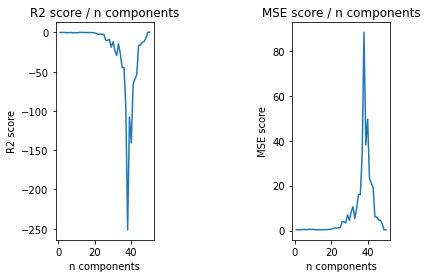

In [41]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [42]:

r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 49 R2 score: 0.2329851287846082
Best n: 49 MSE: 0.26846261358452644


### 6.5  Fitting the model with best correlated features

In [43]:
# Use the best n_components parameter
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print("MSE:", mse)

R2 score: 0.2329851287846082
MSE: 0.26846261358452644


### 6.6   Project extracted features back to original dimension

In [44]:
# Let's try to project the coefs back to the original number of features
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lreg.coef_

pcr_coefs.shape

(333,)

### 6.7  Check out the best correlations

In [45]:
# Let's check which venue types effect the most and least
print('\nMax positive coefs:', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('\nVenue types with most positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)
print('\nMax negative coefs:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('\nVenue types with most negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)
coef_abs = abs(pcr_coefs)
print('\nMin coefs:', pcr_coefs[np.argsort(coef_abs)[:10]])
print('\nVenue types with least effect:', X.columns[np.argsort(coef_abs)[:10]].values)


Max positive coefs: [0.07342754 0.06410964 0.05973685 0.05919881 0.05850579 0.05646244
 0.05268671 0.05268671 0.04710718 0.04488609]

Venue types with most positive effect: ['Shanghai Restaurant' 'Soup Place' 'Library' 'Australian Restaurant'
 'Korean Restaurant' 'Fried Chicken Joint' 'Botanical Garden'
 'Business Service' 'South American Restaurant' 'Jewelry Store']

Max negative coefs: [-0.04331412 -0.04141739 -0.03958839 -0.03828116 -0.0356682  -0.0356682
 -0.03543024 -0.03487916 -0.03487305 -0.03487305]

Venue types with most negative effect: ['Trail' 'Market' 'Coffee Shop' 'Clothing Store' 'Newsstand'
 'Brazilian Restaurant' 'Argentinian Restaurant'
 'Japanese Curry Restaurant' 'Lighthouse' 'Supplement Shop']

Min coefs: [ 0.00015272 -0.00016725 -0.00016725  0.00019045  0.00025978 -0.00030157
 -0.00030157  0.00030458  0.00035201  0.00039732]

Venue types with least effect: ['Financial or Legal Service' 'Molecular Gastronomy Restaurant'
 'Poke Place' 'Event Space' 'Club House' 'Fa

## **7. Conclusions**

Again, the result doesn't seems very promising as the R2 score is still small. The machine learning models can't be used to predict precisely a neighborhood's average house price.

Based on the observed coefficient correlations, we can say that :
1. Fancy places like restaurants seem to boost real estate's value the most.
2. Neighborhoods that have many restaurants are most likely business areas such as downtown. It's where lots of people go to, lots of activities to enjoy, lots of other businesses.
3. Market and Clothing stores also tend to impact the real estate prices by attracting the crowd.
4. Coffe shpos and Lighthouses to a little affect the price as people tend to move in for refreshment.
5. Finally as the result is poor and the correlations are weak, we can say that the real estate prices in NewYork are less according to its surroundings.